In [1]:
!pip install import-ipynb
import import_ipynb

Fields inside 'RELEASE' structured array: ('annolist', 'img_train', 'version', 'single_person', 'act', 'video_list')
Shape of 'annolist': (1, 24987)

Inspecti---- ('image', 'annorect', 'frame_sec', 'vididx')
037454012.jpg
act ::: [[(array([], dtype='<U1'), array([], dtype='<U1'), array([[-1]], dtype=int16))]
 [(array([], dtype='<U1'), array([], dtype='<U1'), array([[-1]], dtype=int16))]
 [(array([], dtype='<U1'), array([], dtype='<U1'), array([[-1]], dtype=int16))]
 ...
 [(array(['transportation'], dtype='<U14'), array(['pushing car'], dtype='<U11'), array([[972]], dtype=uint16))]
 [(array([], dtype='<U1'), array([], dtype='<U1'), array([[-1]], dtype=int16))]
 [(array([], dtype='<U1'), array([], dtype='<U1'), array([[-1]], dtype=int16))]]
Filename for index 0: 037454012.jpg
Filename for index 1: 095071431.jpg
Filename for index 2: 073199394.jpg
Filename for index 3: 059865848.jpg
Filename for index 4: 015601864.jpg
File content/mpii/images/040348287.jpg does not exist. Skipping this it

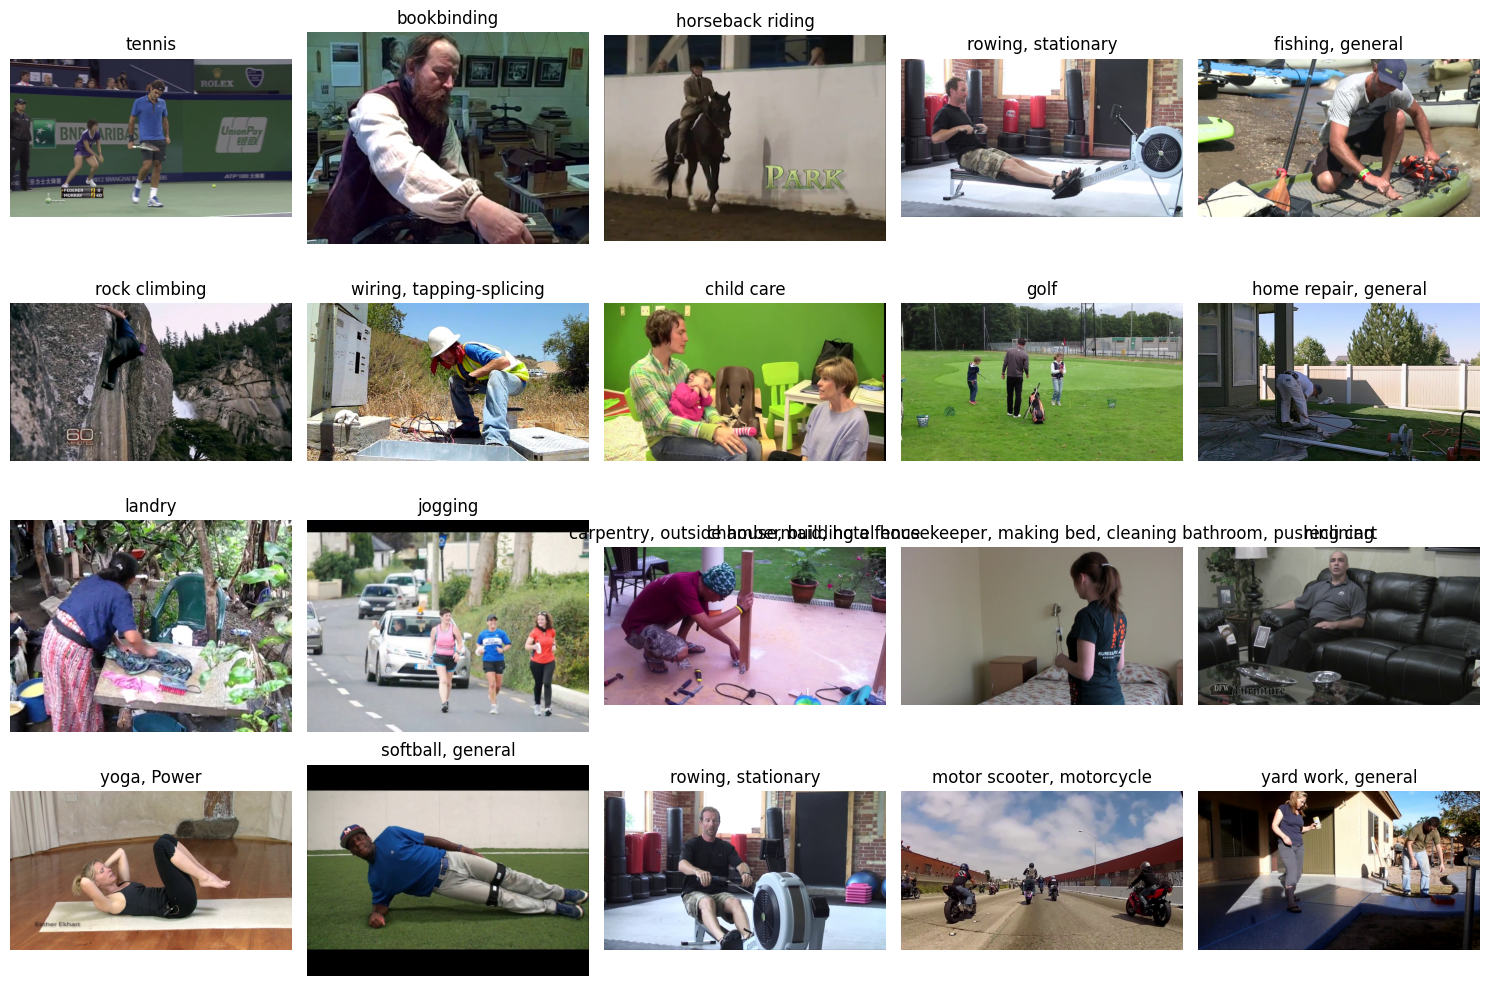

I: 0. Filename ./content/pushups/images?q=tbn:ANd9GcTipRg3kgcAKY1Tkkv3-DdWU3ieLf1D2Ufbgg&s act Name: ['push-ups']
I: 1. Filename ./content/pushups/images?q=tbn:ANd9GcSrq5Rpn32O1LrxtdJ0XHVEeAycjYnD5I1U1Q&s act Name: ['push-ups']
I: 2. Filename ./content/pushups/images?q=tbn:ANd9GcQ1zk-gZtJr_7EKR-lj7Sxbrss-IsFUwFR45A&s act Name: ['push-ups']
I: 3. Filename ./content/pushups/images?q=tbn:ANd9GcStvUucv9ug4dkD0212d969hHxxtN6dmv1ABw&s act Name: ['push-ups']
I: 4. Filename ./content/pushups/images?q=tbn:ANd9GcSFcv_uArv-n5jKvs9B3GEmTSU0EuudGQKaPg&s act Name: ['push-ups']
I: 5. Filename ./content/pushups/images?q=tbn:ANd9GcQSEDvfeLHdYfuizjS297D7Gn588-uhO4kdAA&s act Name: ['push-ups']
I: 6. Filename ./content/pushups/images?q=tbn:ANd9GcTLfIXJxE7iGQ_SJty50yNoHqQfdv1vETz-qA&s act Name: ['push-ups']
I: 7. Filename ./content/pushups/images?q=tbn:ANd9GcRaofQsvW9_l2BcEp89U0Etet77Pa_8ja5RlQ&s act Name: ['push-ups']
I: 8. Filename ./content/pushups/images?q=tbn:ANd9GcQIwJG2jONS2_la_yxpu14_OFo7HtulXYPRQw

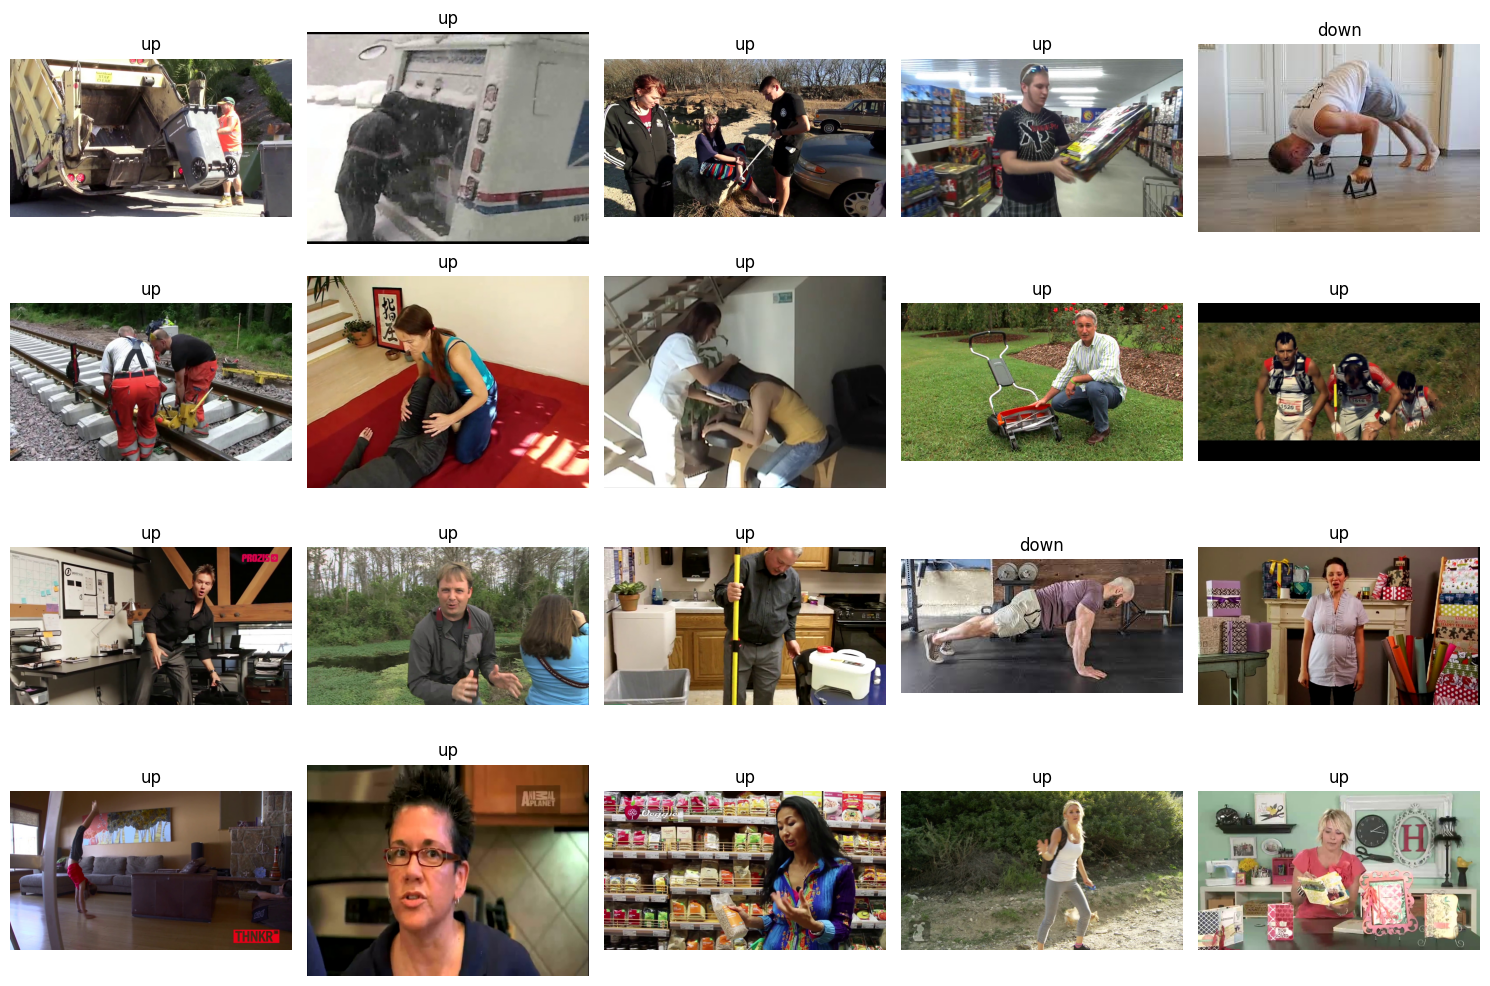

Train dataset size: 14424
Validation dataset size: 1803
Test dataset size: 1803


In [2]:
import import_mpii
#dataset_mpii = import_mpii.dataset
#dataset = dataset_mpii
activities_set = import_mpii.activities_set
#len(dataset_mpii)


train_loader =  import_mpii.train_loader
val_loader = import_mpii.val_loader
test_loader = import_mpii.test_loader

In [3]:
# import import_coco
#
# train_loader =  import_coco.train_loader
# val_loader = import_coco.val_loader
# test_loader = None

In [5]:
import torch

# Because not 42 🤮
random_state = 137  # 🥰

NUM_EPOCHS = 5

DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [7]:
def train_model(train_loader, val_loader, test_loader, model_class=SimpleCNN, epochs=NUM_EPOCHS):
    import torch.optim as optim
    from tqdm import tqdm
    import matplotlib.pyplot as plt

    # Assuming you have num_classes
    num_classes = len(activities_set)

    # Initialize the model, loss function, and optimizer
    model = model_class(num_classes=len(activities_set))
    model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_acc = 0

    # Training loop
    for epoch in range(epochs):
        model.train()
        print("training... 💪")
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (images, labels) in enumerate(train_loader):  # Use tqdm for progress bar
            images, labels = images.to(DEVICE), labels.to(DEVICE)  # Move data to the device
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            predicted = torch.argmax(outputs, dim=1)  # Get the predicted class indices
            train_correct += (predicted == labels).sum().item()  # Compare with labels
            train_total += labels.size(0)  # Track the total number of samples

            if batch_idx % 50 == 0:
                print(f'Epoch [{epoch + 1}/{epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        # Calculate and append training accuracy for this epoch
        train_accuracy = 100 * train_correct / train_total
        train_accuracies.append(train_accuracy)

        print("evaluating... ")
        model.eval()  # Set the model to evaluation mode
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
          for data, target in val_loader:
              # Move data to the selected device
              data, target = data.to(DEVICE), target.to(DEVICE)
              outputs = model(data)
              loss = criterion(outputs, target)
              val_loss += loss.item()

              predicted = torch.argmax(outputs, dim=1)
              total += target.size(0)
              correct += (predicted == target).sum().item()

        val_loss /= len(val_loader)  # Average validation loss
        val_accuracy = 100 * correct / total

        train_losses.append(loss.item()) #for plotting
        val_losses.append(val_loss) #for plotting
        #train_accuracies.append((100 * correct) / total) #for plotting
        val_accuracies.append(val_accuracy) #for plotting

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_weights =  model.state_dict()
            print(f"Saving best model...💾")
            torch.save(best_weights, "best.pt")

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader)}")
        print(f'Epoch [{epoch+1}/{epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    # Plot the loss and accuracy curves
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()
    return best_val_acc

In [9]:
import torch
from models import BiTLikeModel
torch.cuda.empty_cache()
train_model(train_loader, val_loader, test_loader, model_class=BiTLikeModel, epochs=50)

training... 💪
Epoch [1/50], Batch [1/451], Loss: 6.6176
Epoch [1/50], Batch [51/451], Loss: 5.4635
Epoch [1/50], Batch [101/451], Loss: 5.3623
Epoch [1/50], Batch [151/451], Loss: 5.2874
Epoch [1/50], Batch [201/451], Loss: 5.4339
Epoch [1/50], Batch [251/451], Loss: 4.6061
Epoch [1/50], Batch [301/451], Loss: 4.7546
Epoch [1/50], Batch [351/451], Loss: 5.0212
Epoch [1/50], Batch [401/451], Loss: 4.7251
Epoch [1/50], Batch [451/451], Loss: 4.3749
evaluating... 
Saving best model...💾
Epoch 1/50, Loss: 5.070355705041314
Epoch [1/50], Validation Loss: 7.2154, Validation Accuracy: 5.71%
training... 💪
Epoch [2/50], Batch [1/451], Loss: 4.4356
Epoch [2/50], Batch [51/451], Loss: 4.8254
Epoch [2/50], Batch [101/451], Loss: 4.3463
Epoch [2/50], Batch [151/451], Loss: 4.8072
Epoch [2/50], Batch [201/451], Loss: 4.4402
Epoch [2/50], Batch [251/451], Loss: 4.3791
Epoch [2/50], Batch [301/451], Loss: 4.3368
Epoch [2/50], Batch [351/451], Loss: 4.2797
Epoch [2/50], Batch [401/451], Loss: 4.2188
Epo

KeyboardInterrupt: 